# CxVision - Streaming Videos
This notebook will guide you on how to deploy the CxVision Model Package from AWS Marketplace to process streaming videos.

**CxVision - Streaming Videos** allows you to process streaming-related videos in near real-time by executing a trigger for each new video fragment. You just need a mechanism to upload the videos constantly to Amazon S3 and then, a trigger will be executed to start each video processing. 

The following diagram shows the flow of this process:

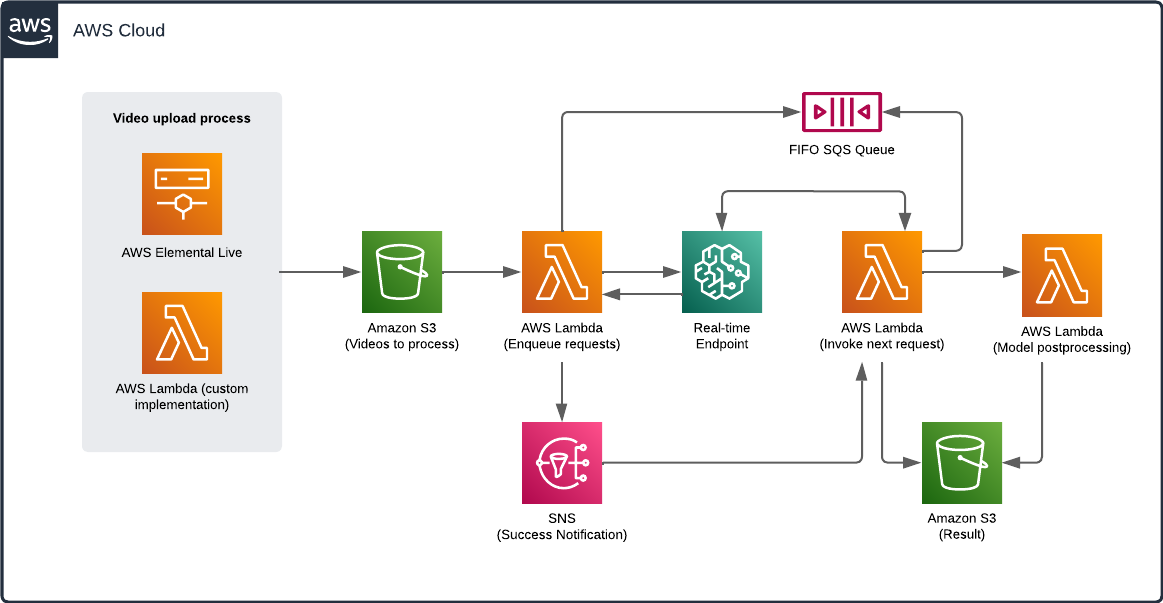

## Usage instructions

Run this Jupyter notebook one cell at a time and press `Shift+Enter` to run each consecutive cell.

## Pre-requisites

1. This notebook renders correctly in Jupyter Notebook interface, so please open this notebook from an Amazon SageMaker Notebook Instance or Amazon SageMaker Studio.
2. Ensure that IAM role used has `AmazonSageMakerFullAccess` policy.
3. To deploy this ML model successfully, ensure that:
   1. You can make AWS Marketplace subscriptions and our IAM role has the following permissions:
      - `aws-marketplace:ViewSubscriptions`
      - `aws-marketplace:Unsubscribe`
      - `aws-marketplace:Subscribe`
4. Create an Amazon S3 Bucket.
5. Create two Amazon SNS topics, for success and failed notifications.


## Contents

1. [Subscribe to the model package](#1.-Subscribe-to-the-model-package)
2. [Create the model](#2.-Create-the-model)
3. [Deploy the model](#Deploy-the-model)
4. [Solution configurations](#4.-Solution-configurations)
5. [Perform inferences](#5.-Perform-inferences)
6. [Visualize results](#6.-Visualize-results)
7. [Clean Up your environment](#7.-Clean-Up-your-environment)

### 1. Subscribe to the model package

1. Open the model package page ["Customer experience vision"]().
2. Click on the **Continue to subscribe** button.
3. On the **Subscribe to this software** page, review it and click on **"Accept Offer"**.
4. Click on **Continue to configuration button** and then select a **region**. The **Product ARN** will be displayed. **This is the model package ARN that you need to specify while creating a deployable model using Boto3.**


### 2. Create the model

Create the model using the ARN of the CXVision Model Package.

In [ ]:
from sagemaker import ModelPackage

sagemaker_role = '<YourSageMakerRole>' # Replace with your IAM Role for Sage Maker
sagemaker_model_package_arn = '<ModelPackageARN>' # Replace this with your subcribed model package ARN

model = ModelPackage(role=sagemaker_role, 
                     model_package_arn=sagemaker_model_package_arn)

### 3. Deploy the model
The following cell deploys a real-time endpoint. Please, replace the params according to your case.

In [ ]:
import uuid

initial_instance_count=1    
instance_type='<InstanceType>' # Replace with your instance type. Supported instances types: ml.g4dn.xlarge, ml.g4dn.2xlarge, ml.g4dn.4xlarge, ml.g4dn.8xlarge, ml.g4dn.12xlarge
job_name='cxvision'

endpoint_name = '{}-{}'.format(job_name,str(uuid.uuid4()))
print('SageMaker Endpoint:',endpoint_name)
    
predictor = model.deploy(
    initial_instance_count=initial_instance_count,
    instance_type=instance_type,
    endpoint_name=endpoint_name
)

print('Enpoint name: {}'.format(endpoint_name))

#### 4.1 Upload the lambda functions code to Amazon S3
Upload the zip files located under the `/lambdaFunctions folder` to Amazon S3.

In [ ]:
import os
import boto3

client = boto3.client('s3')
local_directory = 'lambdaFunctions'
bucket = '<Your_Bucket>' #Put your Amazon S3 Bucket name

for root, dirs, files in os.walk(local_directory):
    for filename in files:
        local_path = os.path.join(root, filename)

        try:
            print("Uploading %s..." % filename)
            client.upload_file(local_path, bucket, filename)
        except:
            print("Error uploading file %s..." % filename)
       

#### 4.2 Define video areas (Dwell and Service)
Please, follow the instructions in the [Define Areas Notebook](./utils/DefineAreas.ipynb) to create the areas object for the videos you will process with the solution. 

#### 4.3 Provision AWS Resources

It's necessary to create the resources specified in the previous diagram. So, please launch the stack using the following CloudFormation template:

 [![Launch Stack](https://cdn.rawgit.com/buildkite/cloudformation-launch-stack-button-svg/master/launch-stack.svg)](https://console.aws.amazon.com/cloudformation/home#/stacks/new?stackName=cxvisionStack&templateURL=https://cxvision.s3.amazonaws.com/cxvision_endpoint_cloudformation.yml)

 > Remember to specify the **endpoint name** (name of the previously deployed endpoint) and the **areas object** (created in step 4.2 with the Define Areas Notebook) as parameters.



The following resources are created using the CloudFormation template:

- **Lambda function (Enqueue videos)**: this function is invoked through an Amazon S3 trigger when a new video is uploaded to a specific Bucket path. The function is in charge of building the payload of the requests to be processed in the endpoint asynchronously, then each request is queued in the FIFO queue and the endpoint is immediately invoked with the first request if the FIFO queue is empty.
- **Lambda function (Invoke endpoint)**: this function is invoked when the asynchronous endpoint completes the execution of a video successfully, sending a success notification to a defined SNS topic. When the function starts, it gets the next request from the FIFO queue and invokes the endpoint with the next video. 
- **Lambda function (Cut videos)**: this function fetches a video from an Amazon S3 Bucket, cuts it into fragments of a certain length and finally uploads them to the Amazon S3 Bucket path that will queue the videos in the FIFO queue. The execution of this function is optional, the customer can define its own method of uploading videos to Amazon S3.
- **Lambda function (Post process result)**: this function generates the final video by drawing bounding boxes in each video frame from the coordinates of the detections (tracking attribute) returned by the model.
- **S3 Bucket**: an Amazon S3 Bucket will be created. This bucket will have all the lambda triggers and will be the input source and the target bucket for processed videos.
- **SQS FIFO Queue**:  the videos to be processed in sequence by the asynchronous endpoint will be uploaded to this queue. This queue must be clean at the moment of the start each execution.
- **SNS Topic**: This sns topic is used to send notifications when a video has been processed successfully.


The invoke AWS Lambda function must have an AWS SNS Trigger associated to your success AWS SNS topic. If not, please go the AWS Lambda function in the AWS console and then add the trigger, such as the image specifies:


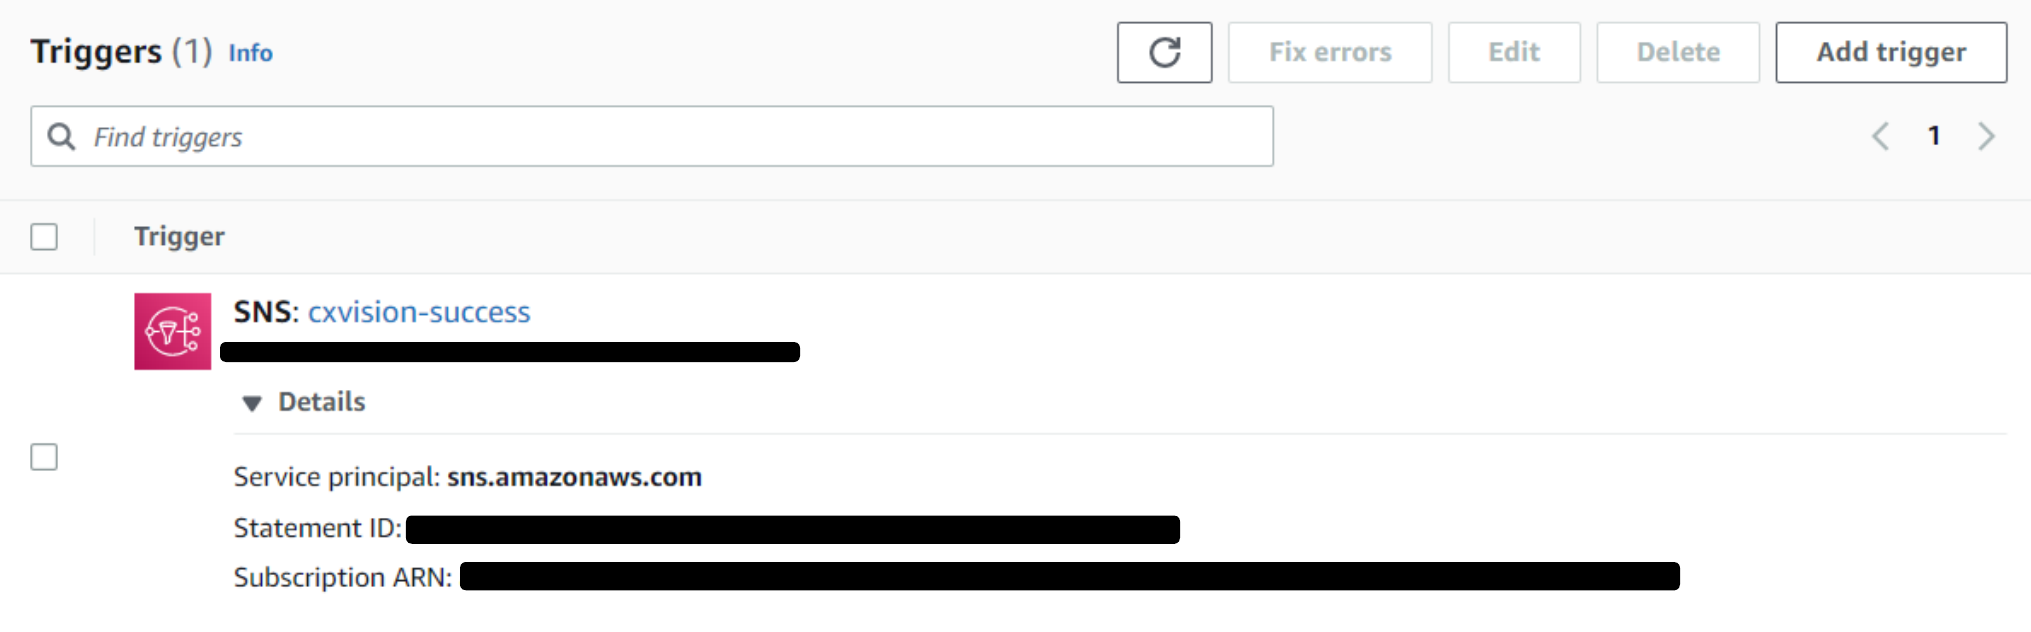





### 5. Perform inferences

To start the inferences, you must upload the videos to the path of the Amazon S3 bucket defined in the CloudFormation template. Once the videos are uploaded to Amazon S3, they will be queued and subsequently processed by the model.


### 6. Visualize results

The results of each video will be uploaded to the Amazon S3 bucket. The results will be:

1. A processed video with the detections of people, times in each zone, and count of these.
2. A JSON file ([See example here](./sample/output/output-model-sample.json)) that contains two main attributes:
    - Tracking: All the detection and tracking information generated by the model.
    - Metrics: An array with the metrics generated per frame. Example:


```
Frame 59 - 2022-12-01 13:07:02.127757. Metric_data: total_detections * 6 * video * maki_japan.mp4 * dwell_detections * 3 * dwell_ids * 1,2,4 * dwell_time * 1,1,1 * service_detections * 3 * service_ids * 3,5,6 * service_time * 1,1,1
```

### 7. Clean Up your environment

#### 7.1. Delete model and endpoint

In [ ]:
model.sagemaker_session.delete_endpoint(endpoint_name)
model.delete_model()

#### 7.2. Unsubscribe (optional)

1. Ensure that you do not have a [running model](https://console.aws.amazon.com/sagemaker/home#/models).
2. Go to __Machine Learning__ tab on [Your Software Subscriptions](https://aws.amazon.com/marketplace/ai/library?productType=ml&ref_=mlmp_gitdemo_indust) page.
2. Locate the listing that you want to cancel the subscription for and then choose __Cancel Subscription__.